# Chapter 13

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)
from scipy.stats import \
    (ttest_1samp,
     ttest_rel,
     ttest_ind,
     t as t_dbn)
from statsmodels.stats.multicomp import \
     pairwise_tukeyhsd
from statsmodels.stats.multitest import \
     multipletests as mult_test

## Exercise 7

In [5]:
Carseats=load_data('Carseats')

### (a)

In [6]:
Carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [7]:
Carseats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Sales        400 non-null    float64 
 1   CompPrice    400 non-null    int64   
 2   Income       400 non-null    int64   
 3   Advertising  400 non-null    int64   
 4   Population   400 non-null    int64   
 5   Price        400 non-null    int64   
 6   ShelveLoc    400 non-null    category
 7   Age          400 non-null    int64   
 8   Education    400 non-null    int64   
 9   Urban        400 non-null    category
 10  US           400 non-null    category
dtypes: category(3), float64(1), int64(7)
memory usage: 26.7 KB


In [8]:
design=MS(Carseats.columns.drop(['Sales','ShelveLoc','Urban','US']))
y=Carseats['Sales']
X=design.fit_transform(Carseats)
X


,intercept,CompPrice,Income,Advertising,Population,Price,Age,Education
0,1.0,138,73,11,276,120,42,17
1,1.0,111,48,16,260,83,65,10
2,1.0,113,35,10,269,80,59,12
3,1.0,117,100,4,466,97,55,14
4,1.0,141,64,3,340,128,38,13
...,...,...,...,...,...,...,...,...
395,1.0,138,108,17,203,128,33,14
396,1.0,139,23,3,37,120,55,11
397,1.0,162,26,12,368,159,40,18
398,1.0,100,79,7,284,95,50,12


In [48]:
Xs=[]
results=[]
p_values=[]
for i in range(1,X.shape[1]):
    Xs.append(X.iloc[:,[0,i]])
for i in range(len(Xs)):
    results.append(sm.OLS(y,Xs[i]).fit())
for i in range(len(results)):
    p_values.append(results[i].pvalues[1])#This way you will prevent pvalues form being rounded
df=pd.DataFrame({'Variables':X.columns.drop(['intercept']),'p_values':p_values})

In [49]:
df

,Variables,p_values
0,CompPrice,2.009398e-01
1,Income,2.309670e-03
2,Advertising,4.377677e-08
3,Population,3.139816e-01
4,Price,7.618187e-21
5,Age,2.788950e-06
6,Education,2.999442e-01


### (b)

If we control the type I error for each the seven models fitted in the previous question at level 5%, then we reject the null hypotheses of the form $H_{0,j}: \beta_{1,j}=0$, associated with variables 'CompPrice', 'Population' and 'Education'.

### (c)

In [59]:
#We use the Holm's step down approach 
alpha=0.05
m=df.shape[0]
df_sorted=df.sort_values(by=['p_values'])
#Step 4 of Holm's step down method
condition=[]
for i in range(df_sorted.shape[0]):
    if df_sorted['p_values'].iloc[i]>alpha/(m+2-i):
        condition.append(i)


In [60]:
L=min(condition)

In [61]:
df_sorted['Reject']=np.where(df_sorted['p_values']<df_sorted['p_values'].iloc[L],'Yes','No')

In [62]:
df_sorted

,Variables,p_values,Reject
4,Price,7.618187e-21,Yes
2,Advertising,4.377677e-08,Yes
5,Age,2.788950e-06,Yes
1,Income,2.309670e-03,Yes
0,CompPrice,2.009398e-01,No
6,Education,2.999442e-01,No
3,Population,3.139816e-01,No


### (d)

In [70]:
qvalues = mult_test(df['p_values'],alpha=0.2, method = "fdr_bh")[0]

In [71]:
df['Reject_FDR_bh']=np.where(qvalues==True,'Yes','No')

In [72]:
df

,Variables,p_values,Reject_FDR_bh
0,CompPrice,2.009398e-01,No
1,Income,2.309670e-03,Yes
2,Advertising,4.377677e-08,Yes
3,Population,3.139816e-01,No
4,Price,7.618187e-21,Yes
5,Age,2.788950e-06,Yes
6,Education,2.999442e-01,No


## Exercise 8

In [2]:
rng = np.random.default_rng (1)
n, m = 20, 100
X = rng.normal(size=(n, m))

In [3]:
X.shape

(20, 100)

### (a)

In [4]:
results = ttest_1samp(X, 0).pvalue

In [5]:
results.shape

(100,)

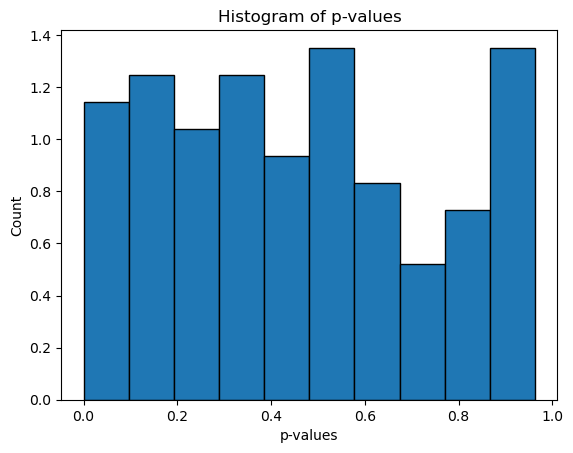

In [6]:
kwargs = dict(histtype='bar', density=True, ec="k")
plt.hist(results,**kwargs)
plt.title('Histogram of p-values')
plt.xlabel('p-values')
plt.ylabel('Count');

The histogram show a relatively flat distribution. This stems from the fact that all null hypotheses are true.<br>
It also invokes that controlling Type I error for each null hypothesis using a unified significance level, as prescribed in the following question, is a bad idea. 

### (b)

In [7]:
(results<0.05).sum()

4

We reject 4 null hypotheses.

### (c)

In [8]:
reject, holm = mult_test(results, method = "holm")[:2]
reject

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

By using Holm step down method, we have failed to reject all null hypotheses.

### (d)

In [9]:
reject_fdr=mult_test(results, method = "fdr_bh")[0]
reject_fdr

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

As the previous question, we have failed to reject all null hypotheses.

### (e)

In [13]:
#Picking the 10 managers who perform well. We consider that performant managers are those whose 
# whose returns are not due to chance; i.e: those with the smallest p-values 
performance=[]
for i in range(X.shape[1]):
    performance.append((results[i].sum(),i))
performance.sort(key=lambda x: x[0], reverse=False)

In [14]:
#Top 10 fund managers
top_10=performance[:10]
top_10_pvals=[]
for i in range(10):
    top_10_pvals.append(results[top_10[i][1]])

In [16]:
top_10

[(0.0008066133772248244, 14),
 (0.009551210237857455, 44),
 (0.022933282067325957, 39),
 (0.035539479614030645, 27),
 (0.05026563447042849, 72),
 (0.05388012638125132, 0),
 (0.06564566802881348, 50),
 (0.07550062589870506, 20),
 (0.07795962307812401, 9),
 (0.0879382731757003, 35)]

In [17]:
#Controlling FWER of the top 10 managers
reject_cp= mult_test(top_10_pvals, method = "holm")[:2]
reject_cp

(array([ True, False, False, False, False, False, False, False, False,
        False]),
 array([0.00806613, 0.08596089, 0.18346626, 0.24877636, 0.30159381,
        0.30159381, 0.30159381, 0.30159381, 0.30159381, 0.30159381]))

In [18]:
#Controlling FDR of the top 10 managers
reject_cp_fdr= mult_test(top_10_pvals, method = "fdr_bh")[:2]
reject_cp_fdr

(array([ True,  True, False, False, False, False, False, False, False,
        False]),
 array([0.00806613, 0.04775605, 0.07644427, 0.0866218 , 0.0866218 ,
        0.0866218 , 0.0866218 , 0.0866218 , 0.0866218 , 0.08793827]))

We reject the null hypothesis corresponding to manager no 14 (Indexes start from 0 to 99), when controlling each of FWER and FDR.

### (f)

The approach of "cherry-picking" when controlling FDR or FWER is misleading.<br><br>
This is because control algorithms (e.g: Holm's step down method or Benjamini-Hochberg) depend on the number of null hypotheses to determine the level of significance.<br><br>
When we cherry-pick we tend to only show what we want, which is in fact a dangerous cognitive bias. For example, here we have falsely showed that the best performant manager owes his achieved returns only to chance.